# **Technical Notebook**

This notebook contains all work done from the data cleaning to the modeling and evaluation stages of this project.

**The Goal:**
The idea behind this project is to predict how much a given customer will spend when visiting an online store.  Once this can be predicted, customers can be sent personalized incentives to make a larger purchase, or to make any purchase at all.  

For example, if we think a customer will spend 150 USD in the store, we can send them a coupon for rewards points or free shipping if they spend 200 USD.  Additionally, if the model predicts a customer will not make a purchase, they can be sent a coupon for 10% off if they make a purchase today.  This personalized marketing could increase revenue.

Additionally, our model will allow us to pinpoint which factors influence spending.  Resources can then be deployed to improve features that deter purchases.


**The Data:**
The data used here comes from Google's online store via [Kaggle](https://www.kaggle.com/c/ga-customer-revenue-prediction/data)

**Notebook Navigation:**
* [Data Cleaning & Processing](#Data-Cleaning-&-Processing)
* [EDA & Visualizations](#EDA-&-Visualizations)
* [Modeling & Evaluation](#Modeling-&-Evaluation)
* [Further Visualizations](#Further-Visualizations)

Note: Throughout this notebook, data is written to and loaded from csv files.  This is so that the notebook can be run modularly instead of only from top to bottom.

# **Data Cleaning & Processing**

The steps taken here include:
* Import original data
* Unpack the nested structure of certain columns
* Group unique categorical values
* Deal with missing values

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import datetime as dt
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, make_scorer, silhouette_score, silhouette_samples, calinski_harabasz_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from joblib import dump, load
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Import Functions

In [2]:
%load_ext autoreload
%autoreload 2
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.cleaning_functions as cleaning_functions
import src.eda_functions as eda_functions
import src.modeling_functions as modeling_functions

This project only uses data on visits from customers located in the US, so we filter our data here.  Because of memory limitations, we will save our filtered data as a csv, then load that csv again in the next step.  Data saved as data1.csv

In [5]:
cleaning_functions.filter_us('../Data/train_v2.csv')

Now unpack the nested structure of the columns in the data set.

In [4]:
df = cleaning_functions.unpack_df()

Loaded data1.csv. Shape: (717217, 60)


Clean the data and save it as data2.csv

In [5]:
cleaning_functions.process_data(df)

/Volumes/My Passport for Mac 5TB/capstonev2/Capstone_Repo/Capstone-Revenue_Prediction/src/cleaning_functions.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_purchase_tos.dropna(inplace=True)
/Volumes/My Passport for Mac 5TB/capstonev2/Capstone_Repo/Capstone-Revenue_Prediction/src/cleaning_functions.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_tos.dropna(inplace=True)


Unpack the 'hits' column.  The 'hits' column is stored in a more deeply nested data structure than the other columns

In [3]:
hits = cleaning_functions.load_hits_df('../Data/data2.csv',nrows=None)

Save the unpacked and processed data file.

In [4]:
hits.to_csv('../Data/data3.csv')

### Pull in Economic Data

Here we pull in historical data on the S&P 500, the US Dollar Index, and the Consumer Confidence Index.  The idea here is that this will help our models control for outside variables that may account for changes in consumer spending.  For example, if consumer confidence is lower one month, our model may predict that a given consumer will spend less.

In [54]:
df = cleaning_functions.add_econ_data('../Data/data3.csv')
df.info()

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (66,76,84,85,93) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


<class 'pandas.core.frame.DataFrame'>
Int64Index: 717217 entries, 0 to 717216
Columns: 126 entries, Unnamed: 0.1 to USDI
dtypes: bool(2), datetime64[ns](1), float64(6), int64(10), object(107)
memory usage: 685.4+ MB


In [55]:
df.to_csv('../Data/data3_v2.csv')
df.head()

,Unnamed: 0.1,channelGrouping,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.continent,geoNetwork.country,...,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,CCI,S&P,USDI
0,0,Referral,2017-10-16,Chrome,desktop,False,Chrome OS,8934116514970143966,Americas,United States,...,None,Other,referral,Other,sites.google.com,1508176307,6,101.3111,2557.639893,93.161
1,1,Direct,2017-10-16,Chrome,mobile,True,Android,7992466427990357681,Americas,United States,...,None,Other,None,Other,(direct),1508201613,1,101.3111,2557.639893,93.161
2,2,Referral,2017-10-16,Chrome,desktop,False,Macintosh,0166277907528479249,Americas,United States,...,None,Other,None,/offer/2145,(direct),1508196701,1,101.3111,2557.639893,93.161
3,3,Organic Search,2017-10-16,Safari,mobile,True,iOS,5983987899933814948,Americas,United States,...,None,None,organic,Other,google,1508177658,1,101.3111,2557.639893,93.161
4,4,Paid Search,2017-10-16,Safari,mobile,True,iOS,6135613929977117121,Americas,United States,...,Other,(Remarketing/Content targeting),cpc,Other,google,1508166431,10,101.3111,2557.639893,93.161


# **EDA & Visualizations**

Most visits to the store appear to result in 0 or low revenue, but there are some outliers.  The largest purchase is for $23k. 

<AxesSubplot:xlabel='revenue_usd'>

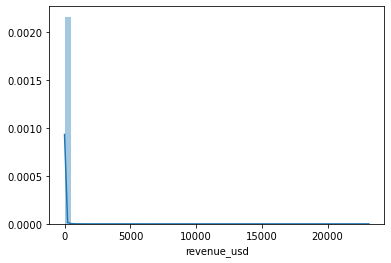

In [106]:
sns.distplot(df['revenue_usd'])

# Purchase vs Non-Purchase

Now we examine how many visits end in a purchase vs no purchase.  The vast majority of site visits end without a purchase of any size being made.

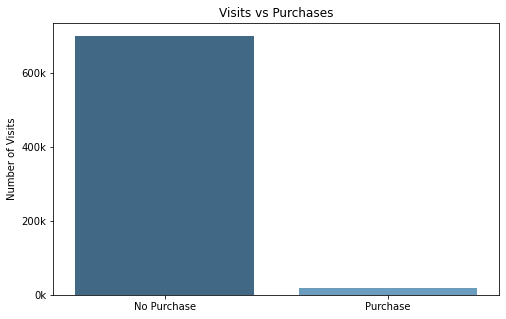

In [107]:
df['purchase'].value_counts()
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=['No Purchase', 'Purchase'], y=df['purchase'].value_counts(), palette='Blues_d')
plt.ylabel('Number of Visits')
plt.title('Visits vs Purchases')
plt.rcParams.update({'font.size': 22})
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: str(round(y / 1000)) + 'k'))

# EDA for site visits that result in purchases

Only 2.46% of site visits end with a purchase of any amount.  Of the visits that end in a purchase, most are under 100 dollars in total.  The average purchase size is $124.

In [108]:
purchases = df.loc[df['totals.transactionRevenue'] != 0]

2.46% of site visitors made a purchase.
The average purchase value is: $124.47


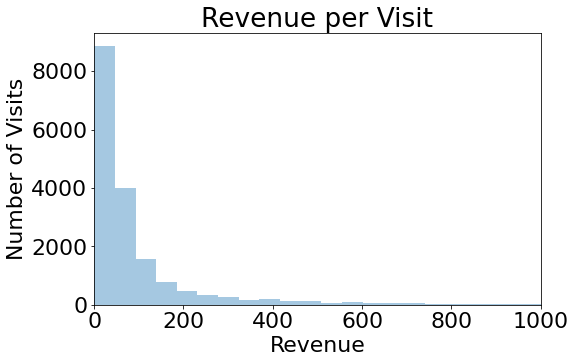

In [109]:
plt.subplots(figsize=(8, 5))
sns.distplot(purchases['revenue_usd'], bins=500, kde=False)
plt.xlim(0, 1000)
plt.xlabel('Revenue')
plt.ylabel('Number of Visits')
plt.title('Revenue per Visit')
plt.rcParams.update({'font.size': 22})


percent_purchase = round(purchases['visitId'].count() / df['visitId'].count() * 100, 2)
print(str(percent_purchase) + "% of site visitors made a purchase.")
print("The average purchase value is: $" + str(round(purchases['revenue_usd'].mean(), 2)))

Of those visitors that make a purchase, the majority of them spend less than 100 dollars.  Average purchase size is $124.47.  Only 2.5% of visits result in a sale of any amount.

# Mobile vs Not

Here we examine spending on mobile devices vs desktop (or similar) devices.  The average purchase size on mobile devices is less than half of the average total from a non-mobile device.  

This could be due to a poor mobile interface or lack of user trust in making large purchases on their phones.

In [110]:
count_mobile = purchases.groupby('device.isMobile').count()
avg_mobile = purchases.groupby('device.isMobile').mean()

Text(0.5, 1.0, 'Average Purchase Amount on Mobile')

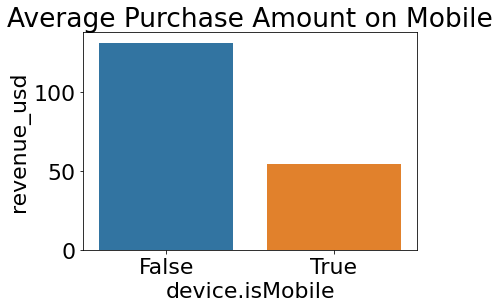

In [111]:
sns.barplot(y=avg_mobile['revenue_usd'], x= avg_mobile.index)
plt.title('Average Purchase Amount on Mobile')

In addition to a smaller average cart size, mobile users also make fewer purchases overall:

Text(0.5, 1.0, 'Number of Purchases on Mobile')

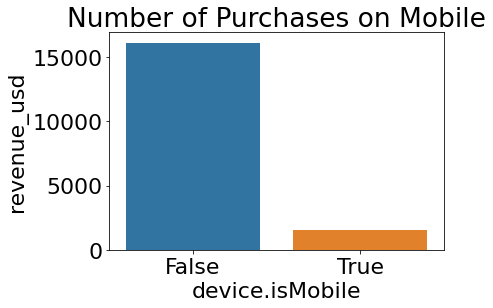

In [112]:
sns.barplot(y=count_mobile['revenue_usd'], x= count_mobile.index)
plt.title('Number of Purchases on Mobile')

# What Percent of Visits End with a Purchase?

Now we examine trends in purchases over time.  In this section we modify our data to time series format and graph trends based on a 4 week rolling average.

In [113]:
df_weekly = eda_functions.percent_purchase(df, 'W')
df_monthly = eda_functions.percent_purchase(df, 'M')

### Weekly % Purchases (Rolling 4 Week Avg)

In any week, about 2.5% to 3.5% of visits ended with a purchase.  This changed in October 2017, when the average percent of visits that result in a purchase declined to about 1.5%.

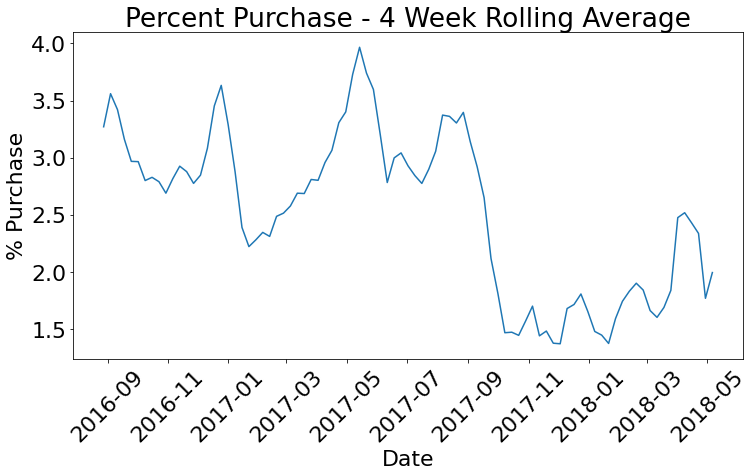

In [114]:
eda_functions.graph_roll_avg_percent_purchase(df_weekly, 4)

One reason for this decrease in the percent of visits that lead to purchases is an increase in overall visits to the site in October 2017.  This corresponds to a large drop of new products from Google.  One possible explanation is that these new products inspired new people to visit the store, but they were not as enthusiastic about buying Google products as previous customers.

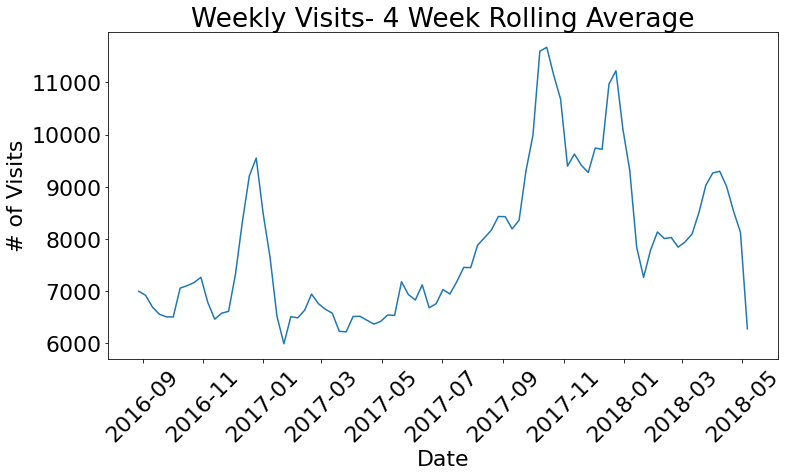

In [115]:
eda_functions.graph_roll_avg_visits(df_weekly, 4)

# What Percent of Visits End with a Purchase?  Mobile vs Not

Now we will repeat the same analysis we did above, while breaking purchases out into those from mobile vs non-mobile devices.

In [116]:
mobile = df.loc[df['device.isMobile'] == True]
non_mobile = df.loc[df['device.isMobile'] == False]

In [117]:
weekly_mobile = eda_functions.percent_purchase(mobile, 'W')
weekly_non_mobile = eda_functions.percent_purchase(non_mobile, 'W')

/Volumes/My Passport for Mac 5TB/capstonev2/Capstone_Repo/Capstone-Revenue_Prediction/src/eda_functions.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype(str)
/Volumes/My Passport for Mac 5TB/capstonev2/Capstone_Repo/Capstone-Revenue_Prediction/src/eda_functions.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date']).dt.normalize()


### % Purchase - Mobile vs Non-Mobile

The trends are similar to what we saw above, but the swings in purchase percent are less pronounced for mobile visits. 

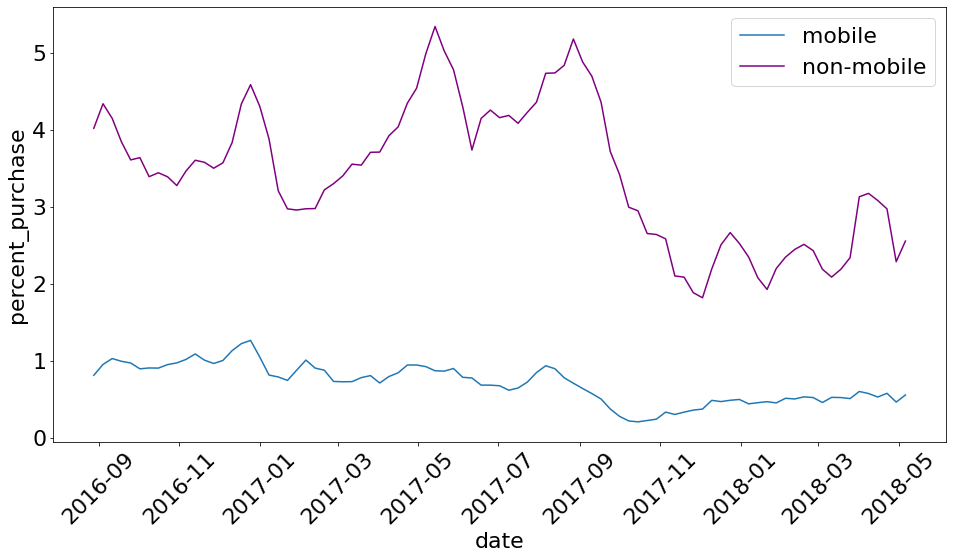

In [118]:
#Graph % for mobile
mobile_rolling_mean = weekly_mobile.rolling(window=4, center=False).mean()
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x=mobile_rolling_mean.index, y="percent_purchase", data=mobile_rolling_mean, label='mobile')
plt.xticks(rotation=45)


#Graph % for non-mobile
non_rolling_mean = weekly_non_mobile.rolling(window=4, center=False).mean()
ax2 = sns.lineplot(x=non_rolling_mean.index, y="percent_purchase", data=non_rolling_mean, color='purple', label='non-mobile')


### Visits per Week - Mobile vs Non-Mobile

Here we can pinpoint the spike in (low purchase rate) mobile visits that lead to the drop in the overall purchase rate.

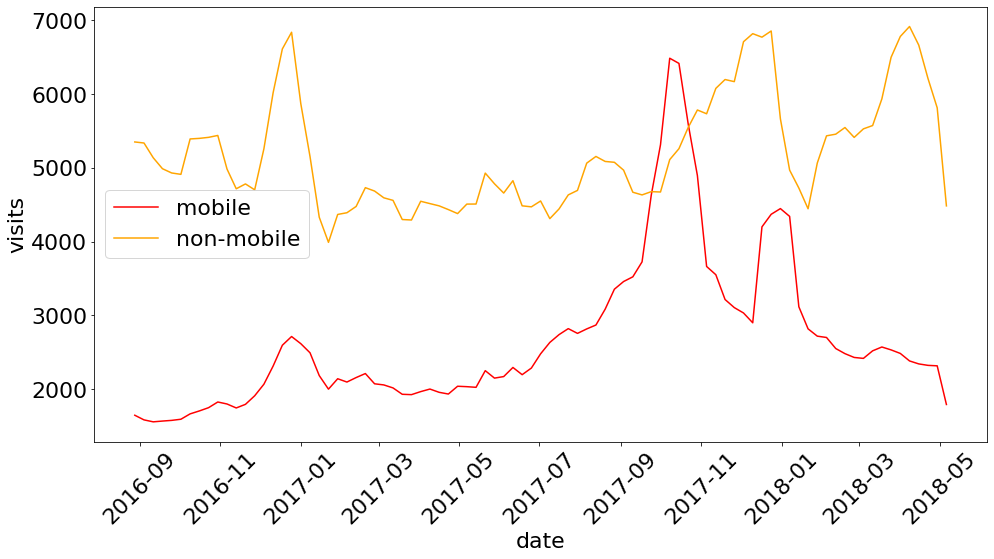

In [119]:
# Mobile visits
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x=mobile_rolling_mean.index, y="visits", data=mobile_rolling_mean, color='red', label = 'mobile')
plt.xticks(rotation=45)


# Non-mobile visits
ax2 = sns.lineplot(x=non_rolling_mean.index, y="visits", data=non_rolling_mean, color='orange', label='non-mobile')
plt.legend()

# Averages by OS

Now we analyze how spending differs based on the operating system of the device that is browsing the store.

In [120]:
df_os = df.loc[df['revenue_usd'] != 0]
df_os_purchase = df_os.groupby('device.operatingSystem').mean().sort_values(by='revenue_usd', ascending=False)

### Avg Spend (of those who made a purchase)

The average purchase size is largest for Windows and Chrome OS machines.  Chrome OS is a Google product, so it makes sense that people who already own Google products would tend to buy more Google products.

Text(0.5, 1.0, 'Average Purchase Amount by Operating System')

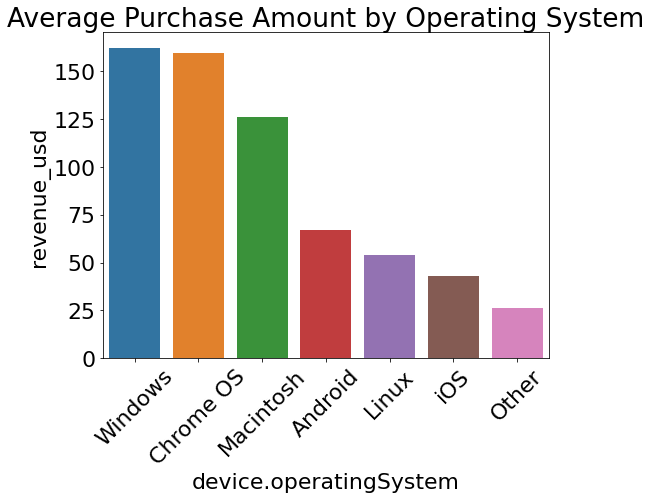

In [121]:
plt.subplots(figsize=(8, 6))
sns.barplot(y=df_os_purchase['revenue_usd'], x= df_os_purchase.index)
plt.xticks(rotation=45)
plt.title('Average Purchase Amount by Operating System')

### Avg % Purchase

Counterintuitively, we see that a large portion of Mac users make a purchase, while a much smaller proportion of Chrome OS users do.

Text(0.5, 1.0, 'Percent of Visits that End in Purchase: by Operating System')

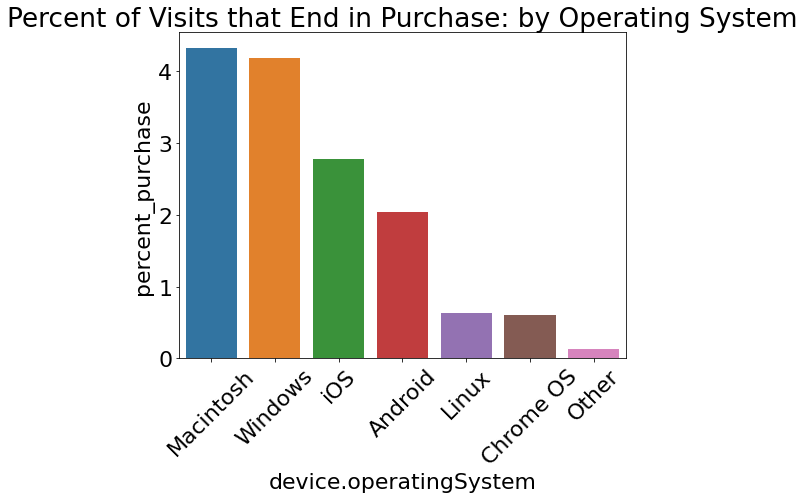

In [122]:
# Groupby OS Count
count = df.groupby('device.operatingSystem').count().sort_values(by='revenue_usd', ascending=False)
count = count[['visitId']]

# Group by OS Sum
total = df.groupby('device.operatingSystem').sum().sort_values(by='revenue_usd', ascending=False)
total = total[['purchase']]

# Calculate Percent
joined = count.join(total, how='inner')
joined['percent_purchase'] = joined['purchase'] / joined['visitId'] * 100

# Graph Percent
plt.subplots(figsize=(8, 6))
sns.barplot(y=joined['percent_purchase'].sort_values(ascending=False), x= joined.index)
plt.xticks(rotation=45)
plt.title('Percent of Visits that End in Purchase: by Operating System')

# Averages by Browser

In [123]:
df_brow = df.loc[df['revenue_usd'] != 0]
df_brow_purchase = df_brow.groupby('device.browser').mean().sort_values(by='revenue_usd', ascending=False)

### Avg Spend (of those who made a purchase)

Firefox users buy far larger amounts than visitors using any other browser.  This could be due to large outlier purchases made by a few Firefox users.  More investigation is warranted.

Text(0.5, 1.0, 'Average Purchase Amount by Browser')

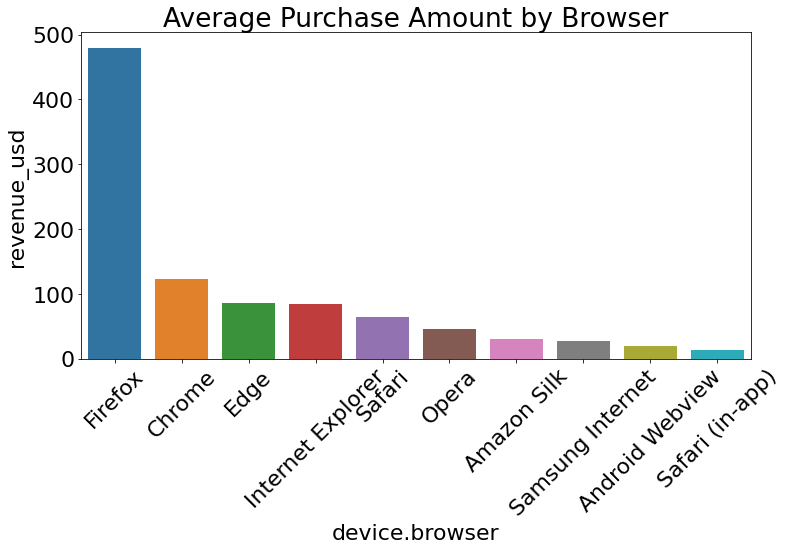

In [124]:
plt.subplots(figsize=(12, 6))
sns.barplot(y=df_brow_purchase['revenue_usd'], x= df_brow_purchase.index)
plt.xticks(rotation=45)
plt.title('Average Purchase Amount by Browser')

### Avg % Purchase

Users that visit the store using Google Chrome make purchases at the highest rate.

Text(0.5, 1.0, 'Percent of Visits that End in Purchase: by Browser')

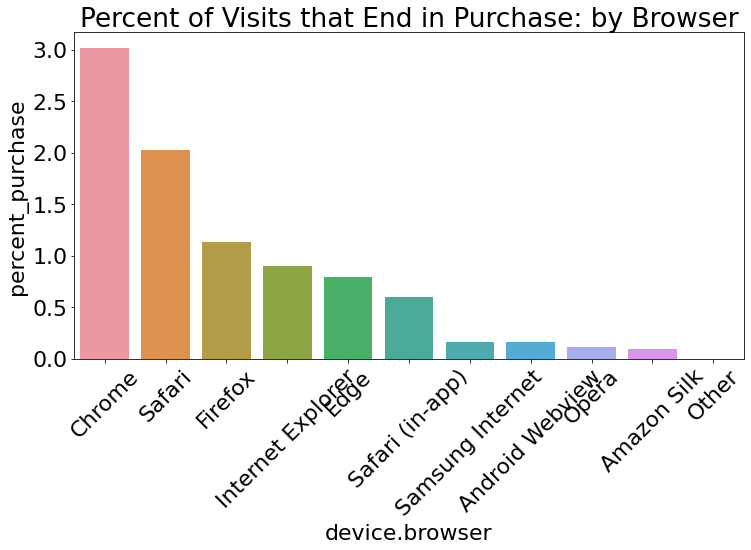

In [125]:
# Groupby OS Count
count = df.groupby('device.browser').count().sort_values(by='revenue_usd', ascending=False)
count = count[['visitId']]

# Group by OS Sum
total = df.groupby('device.browser').sum().sort_values(by='revenue_usd', ascending=False)
total = total[['purchase']]

# Calculate Percent
joined = count.join(total, how='inner')
joined['percent_purchase'] = joined['purchase'] / joined['visitId'] * 100

# Graph Percent
plt.subplots(figsize=(12, 6))
sns.barplot(y=joined['percent_purchase'].sort_values(ascending=False), x= joined.index)
plt.xticks(rotation=45)
plt.title('Percent of Visits that End in Purchase: by Browser')

# **Modeling & Evaluation**

This section of the notebook goes through the stages of modeling before landing on the final Random Forest model used to predict revenue for visits to Google's online store.

**Sections:**
* Process Data for Modeling
* K Means Clustering (Feature Engineering)
* Train Test Split
* Baseline KNN Model
* Tuned KNN Models
* Baseline Decision Tree Model
* Random Forest Models
* Feature Engineering
* Final Model & Evaluation

# Process Data for Modeling

Drop features that do not have predictive capabilities, are duplicates of revenue, or are otherwise unsuitable for regression modeling.

In [3]:
df = cleaning_functions.processing_for_modeling('../Data/data3_v2.csv')

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (66,76,84,85,93) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   device.browser                                717217 non-null  object 
 2   device.deviceCategory                         717217 non-null  object 
 3   device.isMobile                               717217 non-null  bool   
 4   device.operatingSystem                        717217 non-null  object 
 5   geoNetwork.networkDomain                      717217 non-null  object 
 6   revenue_usd                                   717217 non-null  float64
 7   time_of_day                                   717217 non-null  object 
 8   totals.hits                                   717217 non-null  int64  
 9   totals.pageviews                              71

The large range of revenue values, along with the high number of no-purchase visits could present problems for our models.  In order to alleviate possible issues, we'll predict the *natural log* of revenue instead of revenue in USD.

In [42]:
df = pd.read_csv('../Data/data4.csv', dtype={'fullVisitorId': 'str'})
df['ln_revenue_usd'] = np.log(df['revenue_usd'])
df['ln_revenue_usd'] = df['ln_revenue_usd'].apply(lambda x: 0 if x < 0 else x)
df.drop(['Unnamed: 0', 'revenue_usd'], axis=1, inplace=True)

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [43]:
X = df.drop('ln_revenue_usd', axis=1)
Y = df['ln_revenue_usd']

Creating dummy variables with get_dummies.  get_dummies does not drop any categorical columns.  This is not a problem for KNN Regressor, but would need to be updated for models like linear regression.

In [44]:
X_ohe = pd.get_dummies(X)
X_ohe.head()

,device.isMobile,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,trafficSource.adwordsClickInfo.page,visitNumber,CCI,S&P,USDI,...,product_category_Drinkware,product_category_Electronics,product_category_Gift Cards,product_category_Lifestyle,product_category_Limited Supply,product_category_None,product_category_Office,product_category_Other,product_category_Shop by Brand,product_category_TYCTWD 2018
0,False,2,2,2,28,0.0,6,101.3111,2557.639893,93.161,...,0,0,0,0,0,1,0,0,0,0
1,True,2,2,1,38,0.0,1,101.3111,2557.639893,93.161,...,0,0,0,0,0,0,0,0,0,0
2,False,2,2,2,12,0.0,1,101.3111,2557.639893,93.161,...,0,0,0,0,0,0,0,0,0,0
3,True,2,2,1,51,0.0,1,101.3111,2557.639893,93.161,...,1,0,0,0,0,0,0,0,0,0
4,True,2,2,1,111,0.0,10,101.3111,2557.639893,93.161,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering - K Means Clustering

Clustering is another method we can use to add explanatory variables to our model.  Here we use K Means clustering to group our data into clusters.  Once finished, we will add the cluster labels and silhouette scores to our data as additional columns.

## Clustering

Because of limits on computational resources, we scale and do PCA before clustering.  This will decrease multidimensionality and reduce the computer power needed to cluster.

In [45]:
#Create pipeline to reduce data dimensionality
pipe_reduce = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.75, random_state=70))])

In [46]:
X_reduced = pipe_reduce.fit_transform(X_ohe)

Check that dimensionality was reduced & number of samples remained the same.

In [47]:
print(X_ohe.shape)
print(X_reduced.shape)

(717217, 184)
(717217, 79)


Search through a list of values to find the best k value for the KMeans algorithm.  We use the inertia-based elbow method and silhouette scores to decide which k value is 'best'.

In [48]:
distortions = []
silhouette_plot = []
ch_score = []
k_values = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55, 60, 65,70, 75,80, 90, 100, 150, 200, 300]
for k in tqdm(k_values):
    #Create KMeans model object
    clusters = KMeans(n_clusters=k, random_state=70, algorithm='full')
    print("Model Created with k=" + str(k))
    
    #Fit model.
    cluster_fit = clusters.fit(X_reduced)
    print("Model Fit Complete")
    
    #Get predictions for use in silhouette score calculations
    cluster_labels = cluster_fit.predict(X_reduced)
    print("Predictions from Model Complete")
    silhouette_avg = silhouette_score(X_ohe, cluster_labels, sample_size=2500, random_state=70)
    silhouette_plot.append(silhouette_avg)
    ch_score.append(calinski_harabasz_score(X_reduced, cluster_fit.labels_))
    
    #Get inertia value for use in elbow plot
    distortions.append(cluster_fit.inertia_)
    print("Loop Complete for k=" + str(k) + " Model")

  0%|          | 0/22 [00:00<?, ?it/s]

Model Created with k=3
Model Fit Complete
Predictions from Model Complete


  5%|▍         | 1/22 [00:17<05:58, 17.05s/it]

Loop Complete for k=3 Model
Model Created with k=5
Model Fit Complete
Predictions from Model Complete


  9%|▉         | 2/22 [00:36<05:54, 17.72s/it]

Loop Complete for k=5 Model
Model Created with k=10
Model Fit Complete
Predictions from Model Complete


 14%|█▎        | 3/22 [01:02<06:22, 20.15s/it]

Loop Complete for k=10 Model
Model Created with k=15
Model Fit Complete
Predictions from Model Complete


 18%|█▊        | 4/22 [01:33<07:05, 23.64s/it]

Loop Complete for k=15 Model
Model Created with k=20
Model Fit Complete
Predictions from Model Complete


 23%|██▎       | 5/22 [02:12<07:58, 28.15s/it]

Loop Complete for k=20 Model
Model Created with k=25
Model Fit Complete
Predictions from Model Complete


 27%|██▋       | 6/22 [02:59<08:59, 33.72s/it]

Loop Complete for k=25 Model
Model Created with k=30
Model Fit Complete
Predictions from Model Complete


 32%|███▏      | 7/22 [03:54<10:03, 40.22s/it]

Loop Complete for k=30 Model
Model Created with k=35
Model Fit Complete
Predictions from Model Complete


 36%|███▋      | 8/22 [04:53<10:42, 45.91s/it]

Loop Complete for k=35 Model
Model Created with k=40
Model Fit Complete
Predictions from Model Complete


 41%|████      | 9/22 [06:01<11:19, 52.30s/it]

Loop Complete for k=40 Model
Model Created with k=45
Model Fit Complete
Predictions from Model Complete


 45%|████▌     | 10/22 [07:18<11:56, 59.72s/it]

Loop Complete for k=45 Model
Model Created with k=50
Model Fit Complete
Predictions from Model Complete


 50%|█████     | 11/22 [08:45<12:27, 67.99s/it]

Loop Complete for k=50 Model
Model Created with k=55
Model Fit Complete
Predictions from Model Complete


 55%|█████▍    | 12/22 [10:22<12:48, 76.81s/it]

Loop Complete for k=55 Model
Model Created with k=60
Model Fit Complete
Predictions from Model Complete


 59%|█████▉    | 13/22 [12:08<12:48, 85.35s/it]

Loop Complete for k=60 Model
Model Created with k=65
Model Fit Complete
Predictions from Model Complete


 64%|██████▎   | 14/22 [13:59<12:24, 93.11s/it]

Loop Complete for k=65 Model
Model Created with k=70
Model Fit Complete
Predictions from Model Complete


 68%|██████▊   | 15/22 [15:54<11:38, 99.85s/it]

Loop Complete for k=70 Model
Model Created with k=75
Model Fit Complete
Predictions from Model Complete


 73%|███████▎  | 16/22 [18:01<10:46, 107.81s/it]

Loop Complete for k=75 Model
Model Created with k=80
Model Fit Complete
Predictions from Model Complete


 77%|███████▋  | 17/22 [20:13<09:35, 115.10s/it]

Loop Complete for k=80 Model
Model Created with k=90
Model Fit Complete
Predictions from Model Complete


 82%|████████▏ | 18/22 [22:36<08:13, 123.43s/it]

Loop Complete for k=90 Model
Model Created with k=100
Model Fit Complete
Predictions from Model Complete


 86%|████████▋ | 19/22 [25:15<06:42, 134.20s/it]

Loop Complete for k=100 Model
Model Created with k=150
Model Fit Complete
Predictions from Model Complete


 91%|█████████ | 20/22 [30:12<06:06, 183.04s/it]

Loop Complete for k=150 Model
Model Created with k=200
Model Fit Complete
Predictions from Model Complete


 95%|█████████▌| 21/22 [36:13<03:56, 236.26s/it]

Loop Complete for k=200 Model
Model Created with k=300
Model Fit Complete
Predictions from Model Complete


100%|██████████| 22/22 [47:08<00:00, 128.56s/it]

Loop Complete for k=300 Model


Now we plot the inertia values in an elbow plot.

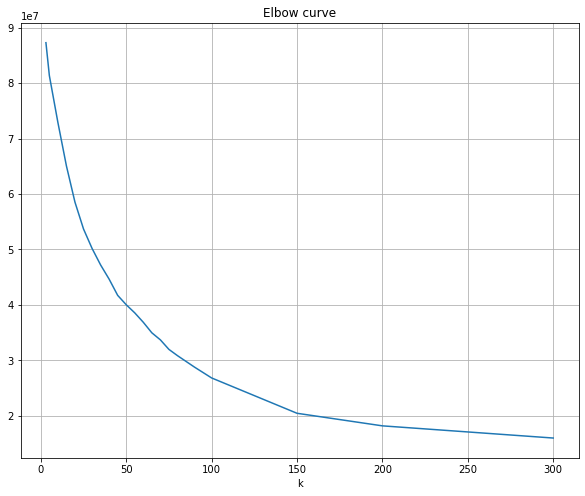

In [49]:
# Plot Inertia Values
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.plot(k_values, distortions)
ax.grid(True)

Next we graph how the silhouette score changes with different values of k.

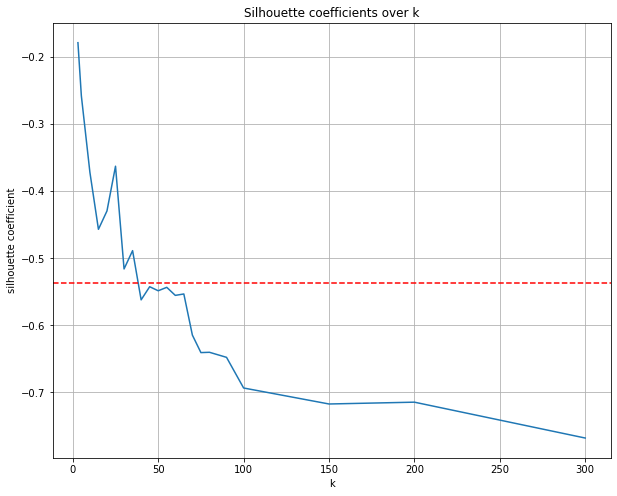

In [50]:
# Plot Silhouette coefficient
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Silhouette coefficients over k')
ax.set_xlabel('k')
ax.set_ylabel('silhouette coefficient')
ax.plot(k_values, silhouette_plot)
ax.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
ax.grid(True)

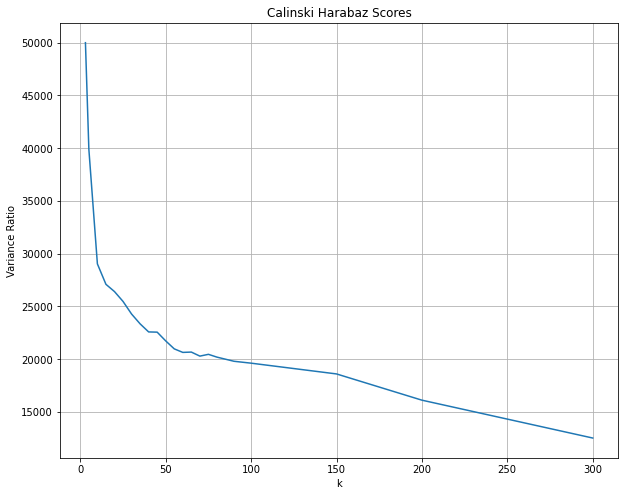

In [51]:
# Plot CH Score Values
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Calinski Harabaz Scores')
ax.set_xlabel('k')
ax.set_ylabel('Variance Ratio')
ax.plot(k_values, ch_score)
ax.grid(True)

A k value of 60 is a good tradeoff between the results of our various scoring metrics.  The CH score is near an inflection point before it begins to trail off.  The silhouette score is close to the average score.  Also, the inertia (which should be minimized) reaches an 'elbow' at k = ~60.  

The average silhouette score is negative, so our clusters are likely not well defined, however the results from our clustering may still add useful features to use in the KNN Regression.

In [52]:
X_fe = modeling_functions.add_clustering(X_ohe, X_reduced, 60)

Done Fitting Model
Done Predicting
Done with Silhouette Scores


In [54]:
print(X_ohe.shape)
print(X_fe.shape)

(717217, 184)
(717217, 186)


# Train Test Split

Split the data into train and test sets.  This will allow us to get a better understanding on how our model will perform on unseen/new data.  All model tuning will be done using cross validation on the training data.  The test data will be used only to test the results of the final model.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_fe, Y, test_size=0.3, random_state=70)

Creating dummy variables with get_dummies.  get_dummies does not drop any categorical columns.  This is not a problem for KNN Regressor, but would need to be updated for models like linear regression.

In [57]:
X_train_ohe_unaligned = pd.get_dummies(X_train)
X_test_ohe_unaligned = pd.get_dummies(X_test)
X_test_ohe_unaligned.head()

,device.isMobile,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,trafficSource.adwordsClickInfo.page,visitNumber,CCI,S&P,USDI,...,product_category_Gift Cards,product_category_Lifestyle,product_category_Limited Supply,product_category_None,product_category_Office,product_category_Other,product_category_Shop by Brand,product_category_TYCTWD 2018,sil_score,cluster_label
451688,True,1,1,-1,239,0.0,1,100.9887,2431.770020,97.239,...,0,0,0,0,0,0,1,0,0.045815,48
47809,False,2,2,1,122,0.0,1,101.0435,2476.350098,92.901,...,0,0,0,0,0,0,0,0,0.053248,8
537920,False,3,3,-1,11,0.0,1,100.4392,2151.330078,98.752,...,0,0,0,0,0,0,0,0,0.116698,8
626702,False,2,2,-1,15,0.0,8,101.0988,2253.280029,101.770,...,0,0,0,1,0,0,0,0,0.177849,35
62574,False,16,10,-1,248,1.0,2,100.3821,2182.639893,94.499,...,0,0,0,0,0,0,1,0,0.151726,9


Align columns in X_test_ohe to match with training data.  Our test data needs to match the training data in structure in order to be used with our final model.

In [58]:
X_train_ohe, X_test_ohe = X_train_ohe_unaligned.align(X_test_ohe_unaligned, join='left', axis=1)

In [59]:
X_test_ohe.fillna(0, inplace=True)

In [60]:
#Save data for modeling
X_train_ohe.to_csv('../Data/X_train.csv')
y_train.to_csv('../Data/y_train.csv')

X_test_ohe.to_csv('../Data/X_test.csv')
y_test.to_csv('../Data/y_test.csv')

# Baseline KNN Model

First we run an untuned model to establish a baseline. Normally wouldn't use PCA in the baseline model, but our computational resources are too limited to make predictions without PCA.  All data must be scaled before using any KNN model.

In [61]:
pipe_knn_baseline = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.9)),
            ('knn', KNeighborsRegressor(p=2, n_jobs=-1))])

Here we will implement a GridSearchCV only for its cross validation properties.  All hyperparameters will be the default values in this baseline model.

In [62]:
# Create the grid parameter
grid_knn_baseline = [{'knn__n_neighbors': [5], 
         'knn__weights': ['uniform']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn_baseline = GridSearchCV(estimator=pipe_knn_baseline, 
                          param_grid=grid_knn_baseline, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1)

In [69]:
gridsearch_knn_baseline.fit(X_train_ohe, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [5],
                          'knn__weights': ['uniform']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [70]:
#Save the model
dump(gridsearch_knn_baseline, 'gridsearch_knn_baseline.joblib') 

['gridsearch_knn_baseline.joblib']

In [71]:
gridsearch_knn_baseline_df = pd.DataFrame.from_dict(gridsearch_knn_baseline.cv_results_)

In [72]:
gridsearch_knn_baseline.best_score_

0.16142725109136496

The mean R-Squared value across all folds of cross validation is 16%.  This is not perfect, but it is large enough to warrant further tuning of a KNN model.  In the next steps we will tune our hyperparameters in order to achieve better results.

# Tuned KNN Model

Now we will tune our KNN model's hyperparameters for the number of nearest neighbors and the weight function used in prediction.

In [6]:
#Create pipeline
pipe_knn = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.8)),
            ('knn', KNeighborsRegressor(p=2, n_jobs=-1))])

In [7]:
# Create the grid parameter
grid_knn = [{'knn__n_neighbors': [5, 10, 20, 50, 100], 
         'knn__weights': ['uniform', 'distance']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn = GridSearchCV(estimator=pipe_knn, 
                          param_grid=grid_knn, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1,
                          verbose=8)

In [8]:
gridsearch_knn.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 134.8min
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed: 313.6min remaining: 59.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 354.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.8)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [5, 10, 20, 50, 100],
                          'knn__weights': ['uniform', 'distance']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=8)

Throughout the notebook the dump/load functions are used to save and load models so that we do not have to re-fit models each time the notebook/kernel is closed or restarted.

In [10]:
#Save the model
dump(gridsearch_knn, 'gridsearch_knn.joblib') 

['gridsearch_knn.joblib']

In [48]:
# gridsearch_knn = load('../Models/gridsearch_knn.joblib')

In [11]:
gridsearch_knn.best_params_

{'knn__n_neighbors': 50, 'knn__weights': 'distance'}

In [12]:
gridsearch_knn.best_score_

0.24993894732633004

The best model we tested used a distance weight function and 50 nearest neighbors to make its predictions.  The average R-Squared value for this model across all CV folds was 25%.  This model also had the lowest RMSE out of the models we tried.  This is a definite improvement over our baseline model (R-Squared of 16%).

Next, we can graph how R-Squared and RMSE change as we modify the number of neighbors.  This will allow us to more accurately target the hyperparameters that will lead to the best result.

In [13]:
#Get results of our modeling.
gridsearch_knn_df = pd.DataFrame.from_dict(gridsearch_knn.cv_results_)
gridsearch_knn_df = gridsearch_knn_df[['param_knn__n_neighbors', 'param_knn__weights', 'mean_test_neg_root_mean_squared_error', 'mean_test_r2']]
gridsearch_knn_df

,param_knn__n_neighbors,param_knn__weights,mean_test_neg_root_mean_squared_error,mean_test_r2
0,5,uniform,-0.584563,0.160726
1,5,distance,-0.588543,0.149252
2,10,uniform,-0.564259,0.218023
3,10,distance,-0.566082,0.212960
4,20,uniform,-0.556240,0.240113
5,20,distance,-0.556103,0.240487
6,50,uniform,-0.554857,0.243897
7,50,distance,-0.552635,0.249939
8,100,uniform,-0.556927,0.238249
9,100,distance,-0.554011,0.246203


In [14]:
#Segment the models into different dataframes depending on the weight function used.
distance_results = gridsearch_knn_df.loc[gridsearch_knn_df['param_knn__weights'] == 'distance'].sort_values(by='param_knn__n_neighbors', ascending=False)
uniform_results = gridsearch_knn_df.loc[gridsearch_knn_df['param_knn__weights'] == 'uniform'].sort_values(by='param_knn__n_neighbors', ascending=False)

### Graph Metrics for Uniform Models

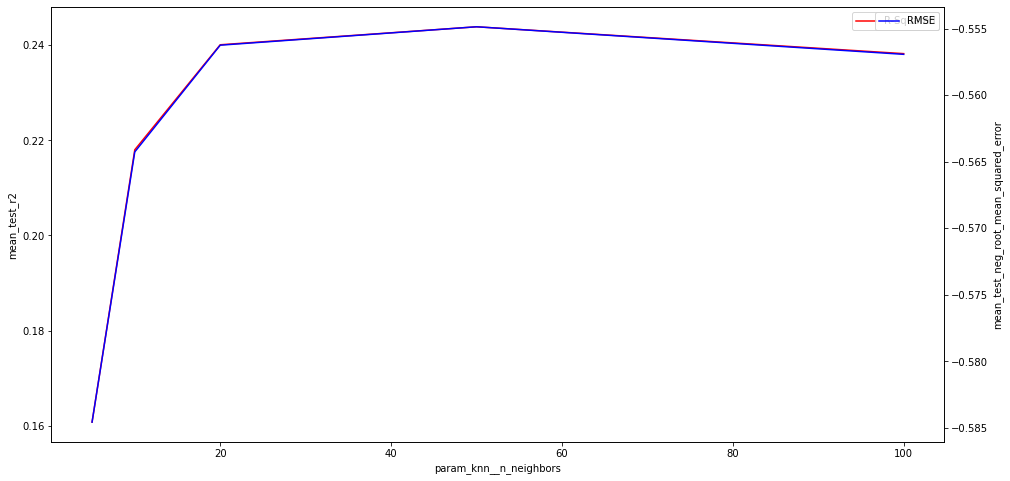

In [15]:
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='param_knn__n_neighbors', y="mean_test_r2", data=uniform_results, color='red', label = 'R-Squared')
ax2=ax.twinx()
sns.lineplot(x='param_knn__n_neighbors', y="mean_test_neg_root_mean_squared_error", data=uniform_results, color='blue', label = 'RMSE')
plt.legend()

Here we can see that R-Squared increases quickly until about k=20, then less quickly until about k=50, then the values begin to decrease.  RMSE shows a similar pattern.

### Graph Metrics for Distance Models

<AxesSubplot:label='803697c1-50ea-40f9-9beb-29dafbd18720', xlabel='param_knn__n_neighbors', ylabel='mean_test_neg_root_mean_squared_error'>

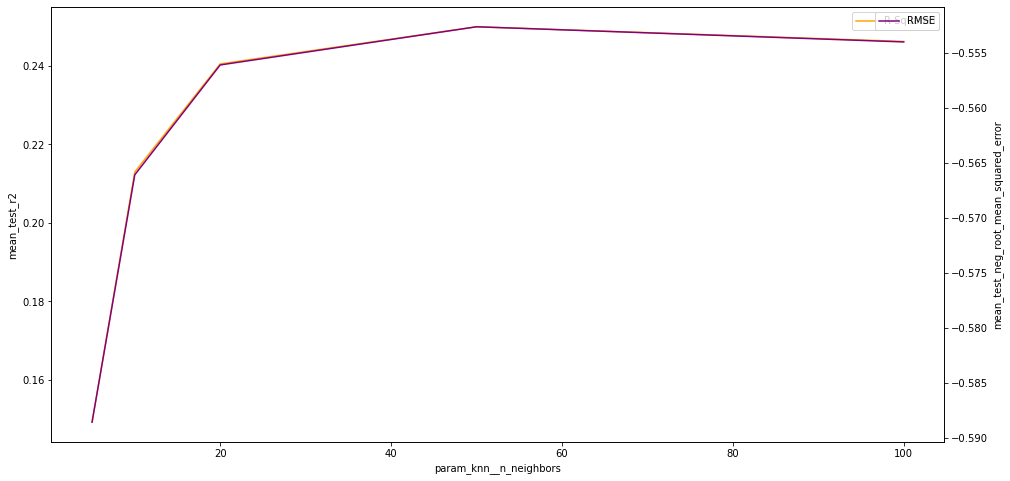

In [16]:
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='param_knn__n_neighbors', y="mean_test_r2", data=distance_results, color='orange', label = 'R-Squared')
ax2=ax.twinx()
sns.lineplot(x='param_knn__n_neighbors', y="mean_test_neg_root_mean_squared_error", data=distance_results, color='purple', label = 'RMSE')

Here we can see that R-Squared increases quickly until about k=20, then less rapidly through k=50 or so.  Then the values begin to decrease.  RMSE shows a similar pattern.

Now we look at the mean R-Squared values for distance vs uniform weight functions.  Below we can see that uniform performs better in certain scenarios, but distance gives us the best few models.  We'll tune our model again using a distance weights and more targeted k values based on the above graphs.

In [17]:
distance_results[['mean_test_r2']]

,mean_test_r2
9,0.246203
7,0.249939
5,0.240487
3,0.212960
1,0.149252


In [18]:
uniform_results[['mean_test_r2']]

,mean_test_r2
8,0.238249
6,0.243897
4,0.240113
2,0.218023
0,0.160726


# 2nd Tuned KNN Model

Here we tune another KNN model with a narrowed range of k values.  This range is based on the results of the previous gridsearch.

In [19]:
# Create the grid parameter using neighbor values based on our previous graphs.
grid_knn_2 = [{'knn__n_neighbors': [45, 55, 60], 
              'knn__weights': ['distance']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn_2 = GridSearchCV(estimator=pipe_knn, 
                          param_grid=grid_knn_2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1,
                          verbose = 8)

In [20]:
gridsearch_knn_2.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 70.2min remaining: 456.6min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 70.8min remaining: 194.7min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 73.1min remaining: 109.7min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 75.6min remaining: 66.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 134.2min remaining: 67.1min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 137.6min remaining: 34.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 137.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.8)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [45, 55, 60],
                          'knn__weights': ['distance']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=8)

In [21]:
#Save the model
dump(gridsearch_knn_2, '../Models/gridsearch_knn_2.joblib') 

['../Models/gridsearch_knn_2.joblib']

In [22]:
gridsearch_knn_2.best_params_

{'knn__n_neighbors': 45, 'knn__weights': 'distance'}

In [23]:
gridsearch_knn_2.best_score_

0.2501761078323534

In [24]:
gridsearch_knn_df2 = pd.DataFrame.from_dict(gridsearch_knn_2.cv_results_).sort_values(by='mean_test_r2', ascending=False)
gridsearch_knn_df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_r2,split1_test_r2,split2_test_r2,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,123.960433,10.557679,4116.885502,50.305416,45,distance,"{'knn__n_neighbors': 45, 'knn__weights': 'dist...",0.256833,0.253623,0.244561,...,0.004846,1,-0.554832,-0.552732,-0.549864,-0.553565,-0.551743,-0.552547,0.001682,1
1,152.526272,34.657176,4030.815740,348.057963,55,distance,"{'knn__n_neighbors': 55, 'knn__weights': 'dist...",0.255765,0.253007,0.243872,...,0.004443,2,-0.555231,-0.552960,-0.550115,-0.553135,-0.551532,-0.552594,0.001712,2
2,204.771121,23.362615,3712.105724,72.455924,60,distance,"{'knn__n_neighbors': 60, 'knn__weights': 'dist...",0.255097,0.252593,0.243355,...,0.004325,3,-0.555480,-0.553113,-0.550303,-0.553109,-0.551673,-0.552736,0.001724,3


Our 2nd iteration of tuning the KNN model results in our best model using 45 nearest neighbors with a distance weighting function.  This model is only slightly better than our previous model both in terms of R-Squared and RMSE.  

However, we've likely reached the limit to how good a KNN model can be with our data.

In [65]:
gridsearch_knn_df2[['mean_test_r2', 'mean_test_neg_root_mean_squared_error']]

,mean_test_r2,mean_test_neg_root_mean_squared_error
0,0.250176,-0.552547
1,0.250051,-0.552594
2,0.249669,-0.552736


We have tuned our KNN model, but the R-Squared metric still is not as high as we might like.  About 25% of the variation in revenue can be explained by our tuned model.  The KNN model is limited both by our computational resources and by how KNN performs when there are many dimensions and many rows.

Additionally, we want to analyze which features are most important in predicting how much a customer spends.  This is not possible with a KNN model.  

Tree-based models do have this functionality.  Our next step is to implement a decision tree regressor.  Once we have a sufficient tree-based model, we will examine the Gini Importance of different features to make conclusions about online shopping at Google's store.

# Decision Tree Model

In tuning this model we need to use a RandomizedSearchCV because our computational resources are limited.  We will tune based on a random selection from the starting hyperparameters, then look for patterns and tune again from there.

Tree-based models in sklearn expect a 1-D array as input for the target variable.  Here we transform our revenue column from a DataFrame to a numpy array.

In [30]:
y_train_1d = y_train['ln_revenue_usd'].ravel()

In [31]:
#Create pipeline
pipe_tree = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.9)),
            ('tree', DecisionTreeRegressor(random_state=70))])

In [32]:
# Create the grid parameter
grid_tree = [{'tree__max_depth': [10, 20, 35, 50], 
             'tree__min_samples_split': [5, 10, 30, 40, 50],
             'tree__min_samples_leaf': [10, 30, 100, 300],
             'tree__criterion': ['mse'],
             'tree__max_features': [None, 'sqrt', 'log2']
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_tree = RandomizedSearchCV(estimator=pipe_tree, 
                          param_distributions=grid_tree, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          cv=5,
                          n_iter=15,
                          n_jobs=-1,
                          verbose=8)

In [33]:
gridsearch_tree.fit(X_train_ohe, y_train_1d)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed: 16.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 17.6min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.9)),
                                             ('tree',
                                              DecisionTreeRegressor(random_state=70))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'tree__criterion': ['mse'],
                                         'tree__max_depth': [10, 20, 35, 50],
                                         'tree__max_features': [None, 'sqrt',
                                                                'log2'],
                                         'tree__min_samples_leaf': [10, 30, 100,
                                                                    300],
                                         'tree__min_samples_split': [5, 10, 30,
                                                                     40, 50]}],
                   refit='r2'

In [34]:
#Save the model
dump(gridsearch_tree, 'gridsearch_tree.joblib') 

['gridsearch_tree.joblib']

In [35]:
gridsearch_tree.best_params_

{'tree__min_samples_split': 40,
 'tree__min_samples_leaf': 300,
 'tree__max_features': None,
 'tree__max_depth': 20,
 'tree__criterion': 'mse'}

The best R-Squared score from this model is 24.2%.  This is lower than our tuned KNN model, but high enough to continue iterating with tree-based models.  A random forest model may be more effective than a single decision tree.

In [36]:
gridsearch_tree.best_score_

0.24179894878237337

In [37]:
gridsearch_tree_df = pd.DataFrame.from_dict(gridsearch_tree.cv_results_)
gridsearch_tree_df.loc[gridsearch_tree_df['rank_test_r2'] < 6]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__min_samples_split,param_tree__min_samples_leaf,param_tree__max_features,param_tree__max_depth,param_tree__criterion,params,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,115.916316,2.181087,3.735438,0.066966,5,100,log2,50,mse,"{'tree__min_samples_split': 5, 'tree__min_samp...",...,0.006064,4,-0.570901,-0.565172,-0.565435,-0.564567,-0.565598,-0.566335,0.002310,4
2,225.733169,9.041061,4.497389,0.644958,40,300,None,20,mse,"{'tree__min_samples_split': 40, 'tree__min_sam...",...,0.001107,1,-0.560090,-0.556571,-0.551497,-0.554877,-0.555142,-0.555635,0.002781,1
5,88.909723,11.794835,4.927525,0.620988,50,300,sqrt,35,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.007238,3,-0.563535,-0.567770,-0.555889,-0.562051,-0.559888,-0.561827,0.003932,3
8,84.022784,12.003199,4.858371,0.146467,50,100,log2,35,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.006064,4,-0.570901,-0.565172,-0.565435,-0.564567,-0.565598,-0.566335,0.002310,4
13,125.399828,6.737885,3.403693,1.318646,40,300,None,10,mse,"{'tree__min_samples_split': 40, 'tree__min_sam...",...,0.001144,2,-0.560005,-0.556656,-0.551219,-0.554907,-0.555747,-0.555707,0.002834,2


Here we can see that our 'best' parameters in terms of R-Squared also achieve the lowest RMSE.

Other trends to note:
* min_samples_split is generally at the higher end of the possible range for the highest ranked hyperparameters.
* max_features is None for most of the highest ranked hyperparameters
* max_depth is mostly in the 10-20 range.
* min_samples_leaf is around 300 for each of the top 3 ranked models.

Next we will use this information to tailor our list of possible hyperparameters and tune again.

# 2nd Iteration - Tuned Decision Tree Model

Here we adjust the grid parameters based on the results of the first model.

In [43]:
# Create the grid parameter
grid_tree2 = [{'tree__max_depth': [15, 20, 25, 30], 
             'tree__min_samples_split': [30, 35, 40, 45],
             'tree__min_samples_leaf': [250, 300, 350],
             'tree__criterion': ['mse'],
             'tree__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_tree2 = RandomizedSearchCV(estimator=pipe_tree, 
                          param_distributions=grid_tree2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          cv=5,
                          n_iter=10,
                          n_jobs=-1,
                          verbose=8)

In [44]:
gridsearch_tree2.fit(X_train_ohe, y_train_1d)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed: 24.3min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 27.0min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.9)),
                                             ('tree',
                                              DecisionTreeRegressor(random_state=70))]),
                   n_jobs=-1,
                   param_distributions=[{'tree__criterion': ['mse'],
                                         'tree__max_depth': [15, 20, 25, 30],
                                         'tree__max_features': [None],
                                         'tree__min_samples_leaf': [250, 300,
                                                                    350],
                                         'tree__min_samples_split': [30, 35, 40,
                                                                     45]}],
                   refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
                   verbose=8)

In [45]:
#Save the model
dump(gridsearch_tree2, 'gridsearch_tree2.joblib') 

['gridsearch_tree2.joblib']

In [46]:
gridsearch_tree2.best_params_

{'tree__min_samples_split': 40,
 'tree__min_samples_leaf': 300,
 'tree__max_features': None,
 'tree__max_depth': 25,
 'tree__criterion': 'mse'}

In [47]:
gridsearch_tree2.best_score_

0.24179894395084336

In [48]:
gridsearch_tree_df2 = pd.DataFrame.from_dict(gridsearch_tree2.cv_results_)
gridsearch_tree_df2.loc[gridsearch_tree_df2['rank_test_r2'] < 6]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__min_samples_split,param_tree__min_samples_leaf,param_tree__max_features,param_tree__max_depth,param_tree__criterion,params,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
2,206.929793,6.738872,5.355128,0.604672,30,300,None,15,mse,"{'tree__min_samples_split': 30, 'tree__min_sam...",...,0.001150,2,-0.560042,-0.556581,-0.551524,-0.554892,-0.555152,-0.555638,0.002757,2
4,278.915253,11.280732,5.696932,0.884295,35,250,None,30,mse,"{'tree__min_samples_split': 35, 'tree__min_sam...",...,0.003700,5,-0.561570,-0.556133,-0.549547,-0.556937,-0.554807,-0.555799,0.003868,5
5,269.536476,12.173557,6.190405,1.032560,40,300,None,25,mse,"{'tree__min_samples_split': 40, 'tree__min_sam...",...,0.001107,1,-0.560090,-0.556571,-0.551497,-0.554877,-0.555142,-0.555635,0.002781,1
6,255.913046,5.924147,5.699895,0.935973,30,250,None,15,mse,"{'tree__min_samples_split': 30, 'tree__min_sam...",...,0.003689,3,-0.561557,-0.556143,-0.549538,-0.556932,-0.554815,-0.555797,0.003866,3
7,257.756217,3.965221,5.779920,0.629204,35,250,None,15,mse,"{'tree__min_samples_split': 35, 'tree__min_sam...",...,0.003689,3,-0.561557,-0.556143,-0.549538,-0.556932,-0.554815,-0.555797,0.003866,3
8,262.855961,5.909268,4.808307,0.540906,45,250,None,25,mse,"{'tree__min_samples_split': 45, 'tree__min_sam...",...,0.003700,5,-0.561570,-0.556133,-0.549547,-0.556937,-0.554807,-0.555799,0.003868,5
9,217.334784,49.040911,2.922597,0.477004,40,250,None,25,mse,"{'tree__min_samples_split': 40, 'tree__min_sam...",...,0.003700,5,-0.561570,-0.556133,-0.549547,-0.556937,-0.554807,-0.555799,0.003868,5


This iteration of tuning did not provide better results compared to the previous iterations.  This is not as accurate as the tuned KNN model, but it gives us the insight that tree-based models could be useful in modeling our data.  

Based on this insight we can move on to use a Random Forest Regressor.  This model will aggregate many different Decision Trees, thus creating a more robust model that is less prone to overfitting.

# Random Forest Model

We start with a wide range of parameters.  This will give us a good starting point, and we can further tune the model in the next iteration.  We remove PCA from the pipeline now.  This will increase the time complexity of our modeling process, but it will allow us to extract meaningful feature importances from our final tuned model.

In [33]:
#Create pipeline
pipe_forest = Pipeline([('scl', StandardScaler()),
            ('forest', RandomForestRegressor(random_state=70, n_jobs=-1, warm_start=True))])

In [35]:
#Create pipeline
pipe_forest = Pipeline([('scl', StandardScaler()),
            ('forest', RandomForestRegressor(random_state=70, n_jobs=-1, warm_start=True))])

# Create the grid parameter
grid_forest = [{'forest__n_estimators': [100, 150, 200],
             'forest__max_depth': [1, 5, 10, 15, 25],
             'forest__min_samples_split': [5, 10, 25, 50], 
             'forest__min_samples_leaf': [5, 10, 25, 50], 
             'forest__criterion': ['mse'],
             'forest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest = RandomizedSearchCV(estimator=pipe_forest, 
                          param_distributions=grid_forest, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=10, #Try 10 hyperparameter combinations
                          n_jobs=4, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [49]:
gridsearch_forest.fit(X_train_ohe, y_train_1d)

In [50]:
gridsearch_forest = load('../Models/gridsearch_forest_ln.joblib')

In [51]:
gridsearch_forest.best_params_

{'forest__n_estimators': 150,
 'forest__min_samples_split': 50,
 'forest__min_samples_leaf': 25,
 'forest__max_features': None,
 'forest__max_depth': 25,
 'forest__criterion': 'mse'}

In [52]:
gridsearch_forest.best_score_

0.3285516821087745

Our best model had hyperparameters that were in the higher ranges of our gridsearch.  Additionally, our result improved on the R-Squared score from our Decision Tree.  Now we will take a look at our best RF models so that we can decide how to proceed.

In [ ]:
#Save the model
# dump(gridsearch_forest, 'gridsearch_forest_ln.joblib') 

Now take a look at our top performing models.

In [53]:
gridsearch_forest_df = pd.DataFrame.from_dict(gridsearch_forest.cv_results_)
best_models = gridsearch_forest_df.loc[gridsearch_forest_df['rank_test_r2'] < 6]

In [54]:
best_models

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__n_estimators,param_forest__min_samples_split,param_forest__min_samples_leaf,param_forest__max_features,param_forest__max_depth,param_forest__criterion,...,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error
1,798.255292,17.052615,5.264001,1.618806,150,25,5,None,10,mse,...,-0.525229,0.003834,4,-0.494146,-0.494440,-0.495794,-0.495503,-0.496621,-0.495301,0.000906
2,657.314326,75.523314,6.686570,0.736529,100,25,50,None,15,mse,...,-0.524891,0.004020,3,-0.499450,-0.500044,-0.501465,-0.501212,-0.502032,-0.500840,0.000950
5,1139.417606,40.415420,5.524138,2.882554,150,50,25,None,25,mse,...,-0.522884,0.004033,1,-0.476397,-0.476774,-0.477962,-0.477575,-0.478593,-0.477460,0.000794
6,745.973494,17.859795,5.870441,1.452048,100,50,25,None,15,mse,...,-0.523147,0.003904,2,-0.479187,-0.479475,-0.480524,-0.480447,-0.481771,-0.480281,0.000911
7,1001.165966,54.024347,7.145596,2.035352,200,10,50,None,10,mse,...,-0.526246,0.003929,5,-0.508310,-0.508684,-0.510323,-0.509974,-0.510871,-0.509632,0.000977


In [55]:
best_models[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
1,"{'forest__n_estimators': 150, 'forest__min_sam...",4,0.322524,0.397542,4,-0.525229,-0.495301
2,"{'forest__n_estimators': 100, 'forest__min_sam...",3,0.323390,0.383991,3,-0.524891,-0.500840
5,"{'forest__n_estimators': 150, 'forest__min_sam...",1,0.328552,0.440161,1,-0.522884,-0.477460
6,"{'forest__n_estimators': 100, 'forest__min_sam...",2,0.327876,0.433526,2,-0.523147,-0.480281
7,"{'forest__n_estimators': 200, 'forest__min_sam...",5,0.319892,0.362173,5,-0.526246,-0.509632


Comparison between the mean train and mean test scores in the table above shows us that our model is overfitting to the training data.  We'll keep this in mind when coming up with the parameters for our next iteration of tuning the model.

In [56]:
best_models['params'][5]

{'forest__n_estimators': 150,
 'forest__min_samples_split': 50,
 'forest__min_samples_leaf': 25,
 'forest__max_features': None,
 'forest__max_depth': 25,
 'forest__criterion': 'mse'}

In [57]:
best_models['params'][6]

{'forest__n_estimators': 100,
 'forest__min_samples_split': 50,
 'forest__min_samples_leaf': 25,
 'forest__max_features': None,
 'forest__max_depth': 15,
 'forest__criterion': 'mse'}

Our 2 best models had scores far above our other models.  We'll use the parameters for these models to narrow in on our choices for our next iteration.
*  'min_samples_split': 50
*  'min_samples_leaf': 25
*  'n_estimators' between 100-150
*  'max_depth between 15 and 25

# 2nd Random Forest Model

Here we tune another iteration of a Random Forest model.  

The previous hyperparameter values are a good starting point, but we need to try to solve the overfitting issue in our next model.  To do this, we increase the possible values for min_samples_split, min_samples_leaf, and n_estimators.  We also decrease the possible values for max_depth.

In [11]:
# Create the grid parameter
grid_forest_v2 = [{'forest__n_estimators': [175],
             'forest__max_depth': [10, 20, 30, 40],
             'forest__min_samples_split': [70, 125, 200], 
             'forest__min_samples_leaf': [50, 90, 150], 
             'forest__criterion': ['mse'],
             'forest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest_v2 = RandomizedSearchCV(estimator=pipe_forest, 
                          param_distributions=grid_forest_v2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=10, #Try 6 hyperparameter combinations
                          n_jobs=3, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [58]:
gridsearch_forest2.fit(X_train_fe, y_train_1d)

In [59]:
gridsearch_forest2 = load('../Models/gridsearch_forest_ln_v2.joblib')

In [60]:
gridsearch_forest2.best_params_

{'forest__n_estimators': 175,
 'forest__min_samples_split': 200,
 'forest__min_samples_leaf': 50,
 'forest__max_features': None,
 'forest__max_depth': 30,
 'forest__criterion': 'mse'}

In [61]:
gridsearch_forest2.best_score_

0.3203889063056743

In [62]:
#Save the model
# dump(gridsearch_forest2, 'gridsearch_forest2.joblib') 

The best R-Squared value decreased in this round of fitting, but the difference between training and test scores decreased dramatically.  This likely means that this model will be more able to handle new unseen data (i.e. our test set).  Because of this lower gap between test and training scores, we'll conduct our next iteration using this model as a starting point.

Our top model in terms of R-Squared also has the best RMSE (0.526).

In [63]:
gridsearch_forest_df2 = pd.DataFrame.from_dict(gridsearch_forest2.cv_results_)
best_models2 = gridsearch_forest_df2.loc[gridsearch_forest_df2['rank_test_r2'] < 6]
best_models2[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
4,"{'forest__n_estimators': 175, 'forest__min_sam...",4,0.317618,0.352966,4,-0.527124,-0.513297
5,"{'forest__n_estimators': 175, 'forest__min_sam...",2,0.320389,0.361578,1,-0.526053,-0.509870
7,"{'forest__n_estimators': 175, 'forest__min_sam...",3,0.319233,0.359055,3,-0.526501,-0.510877
8,"{'forest__n_estimators': 175, 'forest__min_sam...",4,0.317618,0.352966,4,-0.527124,-0.513297
9,"{'forest__n_estimators': 175, 'forest__min_sam...",1,0.320389,0.361578,1,-0.526053,-0.509870


# Final Tuning Iteration - Random Forest Model

In [14]:
# Create the grid parameter
grid_forest_v3 = [{'forest__n_estimators': [200],
             'forest__max_depth': [35, 40, 45],
             'forest__min_samples_split': [200, 300], 
             'forest__min_samples_leaf': [45, 50, 55], 
             'forest__criterion': ['mse'],
             'forest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest_v3 = RandomizedSearchCV(estimator=pipe_forest, 
                          param_distributions=grid_forest_v3, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=8, #Try 6 hyperparameter combinations
                          n_jobs=3, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [64]:
gridsearch_forest_v3.fit(X_train_ohe, y_train_1d)

In [66]:
gridsearch_forest3 = load('../Models/gridsearch_forest_ln_v3.joblib')

In [67]:
# dump(gridsearch_forest3, '../Models/gridsearch_forest3.joblib') 

In [68]:
gridsearch_forest3.best_params_

{'forest__n_estimators': 200,
 'forest__min_samples_split': 200,
 'forest__min_samples_leaf': 45,
 'forest__max_features': None,
 'forest__max_depth': 40,
 'forest__criterion': 'mse'}

In [69]:
gridsearch_forest3.best_score_

0.32079058144114725

In [70]:
gridsearch_forest_df3 = pd.DataFrame.from_dict(gridsearch_forest3.cv_results_).sort_values(by='mean_test_r2', ascending=False)
gridsearch_forest_df3[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
0,"{'forest__n_estimators': 200, 'forest__min_sam...",1,0.320791,0.363247,1,-0.525899,-0.509204
6,"{'forest__n_estimators': 200, 'forest__min_sam...",2,0.320030,0.360078,2,-0.526192,-0.510469
7,"{'forest__n_estimators': 200, 'forest__min_sam...",3,0.317358,0.348962,3,-0.527225,-0.514884
2,"{'forest__n_estimators': 200, 'forest__min_sam...",4,0.317358,0.348962,3,-0.527225,-0.514884
3,"{'forest__n_estimators': 200, 'forest__min_sam...",5,0.317002,0.347763,5,-0.527363,-0.515357
1,"{'forest__n_estimators': 200, 'forest__min_sam...",6,0.317002,0.347763,5,-0.527363,-0.515357
4,"{'forest__n_estimators': 200, 'forest__min_sam...",7,0.316487,0.346562,7,-0.527561,-0.515832
5,"{'forest__n_estimators': 200, 'forest__min_sam...",7,0.316487,0.346562,7,-0.527561,-0.515832


In [71]:
gridsearch_forest_df3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__n_estimators,param_forest__min_samples_split,param_forest__min_samples_leaf,param_forest__max_features,param_forest__max_depth,param_forest__criterion,...,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error
0,1130.307894,1.316040,2.226816,0.084633,200,200,45,None,40,mse,...,-0.525899,0.003970,1,-0.507825,-0.508356,-0.509984,-0.509480,-0.510373,-0.509204,0.000967
6,1127.691944,7.337851,2.934206,0.722138,200,200,55,None,35,mse,...,-0.526192,0.003924,2,-0.509108,-0.509575,-0.511218,-0.510794,-0.511651,-0.510469,0.000971
7,968.424890,301.441741,2.474724,0.466504,200,300,45,None,45,mse,...,-0.527225,0.003885,3,-0.513354,-0.514059,-0.515691,-0.515230,-0.516085,-0.514884,0.001023
2,1149.821852,4.690012,2.734221,0.688965,200,300,45,None,40,mse,...,-0.527225,0.003885,3,-0.513354,-0.514059,-0.515691,-0.515230,-0.516085,-0.514884,0.001023
3,1144.998496,6.844813,2.461212,0.341912,200,300,50,None,40,mse,...,-0.527363,0.003844,5,-0.513849,-0.514532,-0.516137,-0.515693,-0.516576,-0.515357,0.001016
1,1125.623629,12.511537,2.601756,0.510573,200,300,50,None,45,mse,...,-0.527363,0.003844,5,-0.513849,-0.514532,-0.516137,-0.515693,-0.516576,-0.515357,0.001016
4,1118.891736,15.102836,2.509245,0.266936,200,300,55,None,40,mse,...,-0.527561,0.003860,7,-0.514367,-0.514995,-0.516569,-0.516121,-0.517107,-0.515832,0.001010
5,1116.692281,4.064373,3.389851,1.199001,200,300,55,None,45,mse,...,-0.527561,0.003860,7,-0.514367,-0.514995,-0.516569,-0.516121,-0.517107,-0.515832,0.001010


R-Squared value increased slightly while the distance between training and test scores stayed about the same.  We'll use this model as our final iteration.

# Final Model

## Model Fitting

Now we actually fit the model on our training data using the best parameters from the grid search.  We do not include PCA in the pipeline so that we can extract usable feature importances from the model.

In [72]:
#Create pipeline
pipe_best_forest = Pipeline([('scl', StandardScaler()),
            ('forest', RandomForestRegressor(n_estimators = 200,
                                             min_samples_split=200,
                                             min_samples_leaf=45,
                                             max_features=None,
                                             max_depth=40,
                                             criterion='mse',
                                             random_state=70,
                                             n_jobs=-1,
                                             warm_start=True))])

In [73]:
pipe_best_forest.fit(X_train_ohe, y_train_1d)

Pipeline(steps=[('scl', StandardScaler()),
                ('forest',
                 RandomForestRegressor(max_depth=40, max_features=None,
                                       min_samples_leaf=45,
                                       min_samples_split=200, n_estimators=200,
                                       n_jobs=-1, random_state=70,
                                       warm_start=True))])

In [74]:
#Save the model
dump(pipe_best_forest, 'best_forest_model.joblib') 

['best_forest_model.joblib']

## Examine Most Important Features

Using the results of the final random forest model, we can see the most important features in predicting revenue.  Further analysis is available in the Results_Analysis.ipynb notebook, or in the Presentation.pdf

In [75]:
importances = pd.Series(pipe_best_forest['forest'].feature_importances_, name='importance')

In [76]:
feature = pd.Series(list(X_train_ohe.columns), name='feature')

In [77]:
feature_importances = pd.concat([feature, importances], axis=1)
top_features = feature_importances.sort_values(by='importance', ascending=False).head(20)
dump(top_features, '../Data/top_features.joblib')

['../Data/top_features.joblib']

In [78]:
top_features

,feature,importance
2,totals.pageviews,0.599385
4,totals.timeOnSite,0.077076
6,visitNumber,0.073121
3,totals.sessionQualityDim,0.046054
144,trafficSource.referralPath_None,0.032282
9,USDI,0.021752
8,S&P,0.019761
1,totals.hits,0.019631
10,product_price,0.013120
184,sil_score,0.011374


## Model Evaluation vs Test Data

First we import the test data that we saved earlier.

In [81]:
X_test_ohe = pd.read_csv('../Data/X_test.csv')
X_test_ohe.drop('Unnamed: 0', axis=1, inplace=True)

y_test = pd.read_csv('../Data/y_test.csv')
y_test.drop('Unnamed: 0', axis=1, inplace=True)

Now the test data is in the proper format to score our model.  We get the R-Squared score using the pipeline from our best Random Forest model.

In [82]:
pipe_best_forest.score(X_test_ohe, y_test)

0.32557347041773055

The model performs even better on the test data!  This is likely somewhat of a fluke due to the random nature of our sampling, however, it is clear that there is no issue with overfitting with our model.

# **Further Visualizations**

This section of the notebook contains analysis of the most important features of our data in terms of predicting revenue from a visit to the online store.

First we determine the most important features.  Next we explore the relationship between these features and the amount of revenue generated from a visit to the store.

In [83]:
df = pd.read_csv('../Data/data4.csv', dtype={'fullVisitorId': 'str'})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   device.browser                                717217 non-null  object 
 2   device.deviceCategory                         717217 non-null  object 
 3   device.isMobile                               717217 non-null  bool   
 4   device.operatingSystem                        717217 non-null  object 
 5   geoNetwork.networkDomain                      717217 non-null  object 
 6   revenue_usd                                   717217 non-null  float64
 7   time_of_day                                   717217 non-null  object 
 8   totals.hits                                   717217 non-null  int64  
 9   totals.pageviews                              71

After importing the data set, separate into multiple DataFrames: One for visits that end with a purchase, and one for visits where no purchase is made.  This will be useful in our analysis of features.

In [84]:
purchase = df.loc[df['revenue_usd'] != 0]
no_purchase = df.loc[df['revenue_usd'] == 0]

The top 20 features from the final Random Forest model are shown below.  We will analyze the data in the most important categories/features below.

In [85]:
top_features = load('../Data/top_features.joblib')
top_features

,feature,importance
2,totals.pageviews,0.599385
4,totals.timeOnSite,0.077076
6,visitNumber,0.073121
3,totals.sessionQualityDim,0.046054
144,trafficSource.referralPath_None,0.032282
9,USDI,0.021752
8,S&P,0.019761
1,totals.hits,0.019631
10,product_price,0.013120
184,sil_score,0.011374


# Top 10 Features

Here we visualize the top 10 features, sorted by importance in our random forest model.  We exclude the results from our clustering algorithm in this chart so that only direct customer attributes and economic data are visualized.

In [89]:
tf = top_features.head(11).reset_index().drop('index', axis=1)
tf.drop([9], inplace=True)
tf = tf.reset_index().drop('index', axis=1)
tf

,feature,importance
0,totals.pageviews,0.599385
1,totals.timeOnSite,0.077076
2,visitNumber,0.073121
3,totals.sessionQualityDim,0.046054
4,trafficSource.referralPath_None,0.032282
5,USDI,0.021752
6,S&P,0.019761
7,totals.hits,0.019631
8,product_price,0.013120
9,device.isMobile,0.009761


Now graph the importances of each feature.  This shows that the number of pages viewed on the online store is by far the most important feature in predicting revenue.  This makes sense; if a customer only visits one page, they likely didn't like what they saw and will move on to a different store.

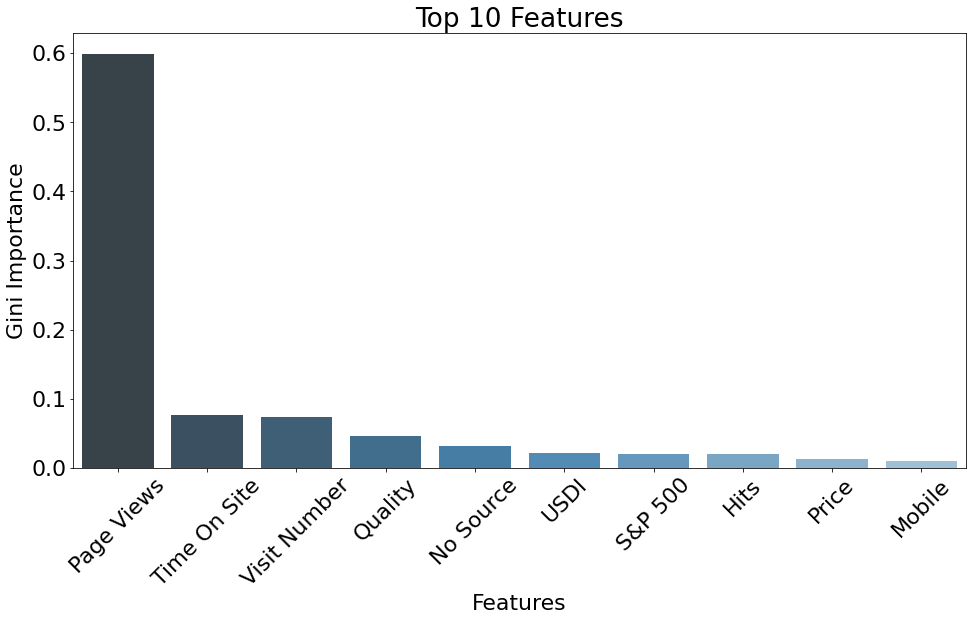

In [91]:
#Format Feature Names for Graph
tf_labels = ['Page Views', 'Time On Site', 'Visit Number', 'Quality', 'No Source', 'USDI', 'S&P 500', 'Hits', 'Price', 'Mobile']

#Graph
plt.subplots(figsize=(16, 8))

plt.xticks(rotation=45)

plt.title('Top 10 Features')
ax = sns.barplot(x=tf_labels, y='importance', data=tf, palette='Blues_d')

plt.ylabel('Gini Importance')
plt.xlabel('Features')
plt.rcParams.update({'font.size': 22})

Now we will visualize the relationships between these top features and revenue:

# Number of Visits to the Store

What is the relationship between revenue and number of visits to the store a customer has made?  Here we only consider the visits that result in a purchase.

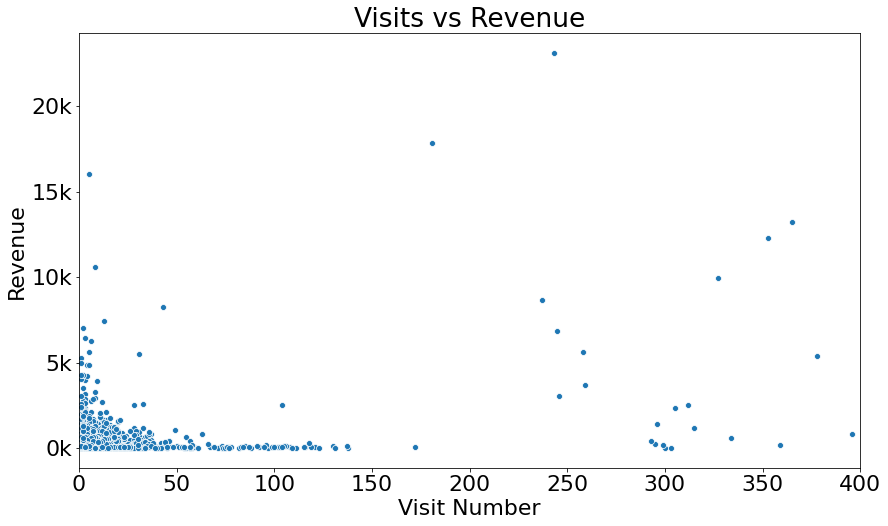

In [92]:
# Revenue vs Visits to Store
plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='visitNumber', y='revenue_usd', data=purchase)
plt.xlim(0, 400)
plt.ylabel('Revenue')
plt.xlabel('Visit Number')
plt.title('Visits vs Revenue')
plt.rcParams.update({'font.size': 22})
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: str(round(y / 1000)) + 'k'))

We can see that most purchases are made within the first 30 or so visits to the Google store.  Large purchases are likely to be made in the first ~20 visits to the store.  As visits increase past 50, purchase amounts grow smaller.  This could be attributed to customers that repeatedly visit the store for small goods that wear out quickly like earbuds, chargers, and gift cards.

Also note that there are a few customers that visited the store hundreds of times in our data collection period.  These customers tended to spend more.  These outlier observations could be negatively impacting the predictive power of our model.  In further iterations of this project we will consider removing these visits from the dataset.

Now we consider the median visit number for visits that end in purchases vs those that do not.  We see that the average number of visits for those that make a purchase (2 visits) is almost double that of those that do not make a purchase.  We can infer that many customers only go to the store once, decide they do not want a Google product, then never return to the store.

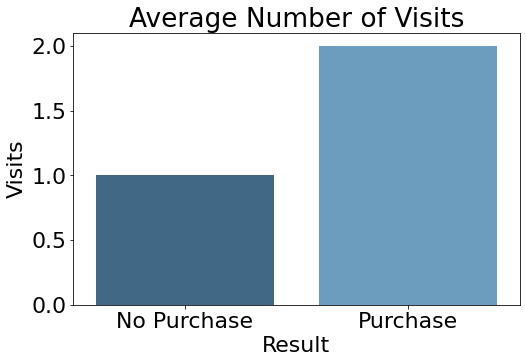

In [93]:
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=['No Purchase', 'Purchase'], 
                 y=[no_purchase['visitNumber'].median(), 
                    purchase['visitNumber'].median()], 
                 palette='Blues_d')
# plt.xlabel('Visit Type')
plt.ylabel('Visits')
plt.xlabel('Result')

plt.title('Average Number of Visits')
plt.rcParams.update({'font.size': 22})

# Number of Pages Viewed in Visit to the Store

Now examine the number of pages viewed, and its relationship with revenue.  This appears to have a negative relationship with revenue.  As page views pass 100, revenue tends to drop.

We will consider excluding outlier page views from future iterations of modeling.

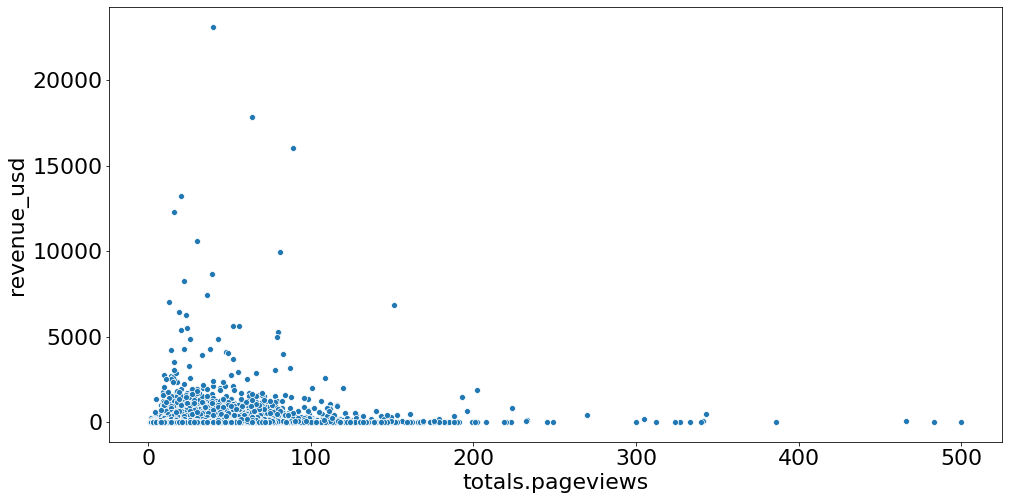

In [94]:
# Revenue vs Pages Viewed on Site
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='totals.pageviews', y='revenue_usd', data=df)

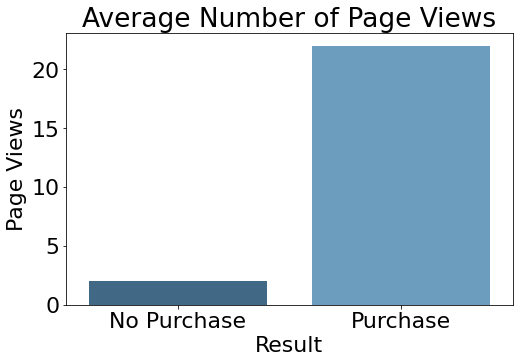

In [96]:
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=['No Purchase', 'Purchase'], 
                 y=[no_purchase['totals.pageviews'].median(), 
                    purchase['totals.pageviews'].median()], 
                 palette='Blues_d')
# plt.xlabel('Visit Type')
plt.ylabel('Page Views')
plt.xlabel('Result')

plt.title('Average Number of Page Views')
plt.rcParams.update({'font.size': 22})

In [106]:
bin_names = ['1', '2-10', '11-50', '51-100', '>100']
bin_numbers = [0, 2, 11, 51, 101, 999999999]
purchase['views_bins'] = pd.cut(purchase['totals.pageviews'], bins = bin_numbers, labels = bin_names)

<ipython-input-106-813d0f347ccf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase['views_bins'] = pd.cut(purchase['totals.pageviews'], bins = bin_numbers, labels = bin_names)


In [107]:
views = purchase.groupby('views_bins').median()
views[['revenue_usd']]

,revenue_usd
views_bins,
1,79.99
2-10,37.49
11-50,44.79
51-100,98.92
>100,127.22


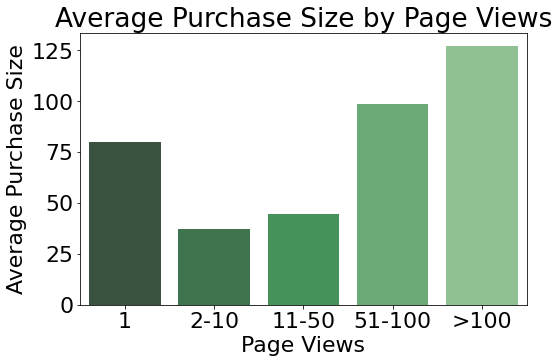

In [108]:
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=views.index, 
                 y=views['revenue_usd'], 
                 palette='Greens_d')
# plt.xlabel('Visit Type')
plt.ylabel('Average Purchase Size')
plt.xlabel('Page Views')

plt.title('Average Purchase Size by Page Views')
plt.rcParams.update({'font.size': 22})

In [109]:
bin_names = ['1', '2-10', '11-50', '51-100', '>100']
bin_numbers = [0, 2, 11, 51, 101, 999999999]
no_purchase['views_bins'] = pd.cut(no_purchase['totals.pageviews'], bins = bin_numbers, labels = bin_names)

<ipython-input-109-9f2c9d01f9a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_purchase['views_bins'] = pd.cut(no_purchase['totals.pageviews'], bins = bin_numbers, labels = bin_names)


In [112]:
views_purch_count = purchase.groupby('views_bins').count()
views_purch_count['purchases'] = views_purch_count['revenue_usd']

views_no_purch_count = no_purchase.groupby('views_bins').count()
views_no_purch_count['non_purchases'] = views_no_purch_count['revenue_usd']

views_purch_count['Percent_Purchase'] = views_purch_count['purchases'] / (views_purch_count['purchases'] + views_no_purch_count['non_purchases']) * 100
views_purch_count[['Percent_Purchase']]

,Percent_Purchase
views_bins,
1,0.001338
2-10,0.653298
11-50,20.353810
51-100,42.878561
>100,42.500000


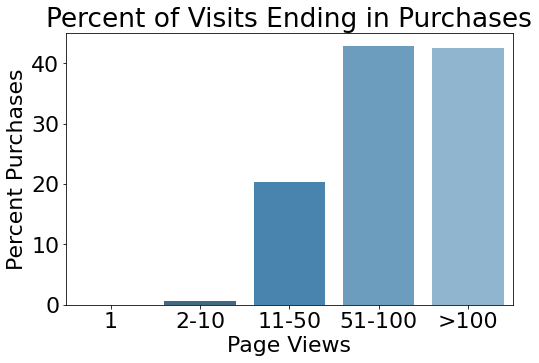

In [113]:
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=views_purch_count.index, 
                 y=views_purch_count['Percent_Purchase'], 
                 palette='Blues_d')
# plt.xlabel('Visit Type')
plt.ylabel('Percent Purchases')
plt.xlabel('Page Views')

plt.title('Percent of Visits Ending in Purchases')
plt.rcParams.update({'font.size': 22})

# Time Spent in the Online Store

Time spent on the site has a similar relationship to revenue as number of pages visited.  This is to be expected, as more time on the site is likely correlated to how many pages are viewed in a given visit.

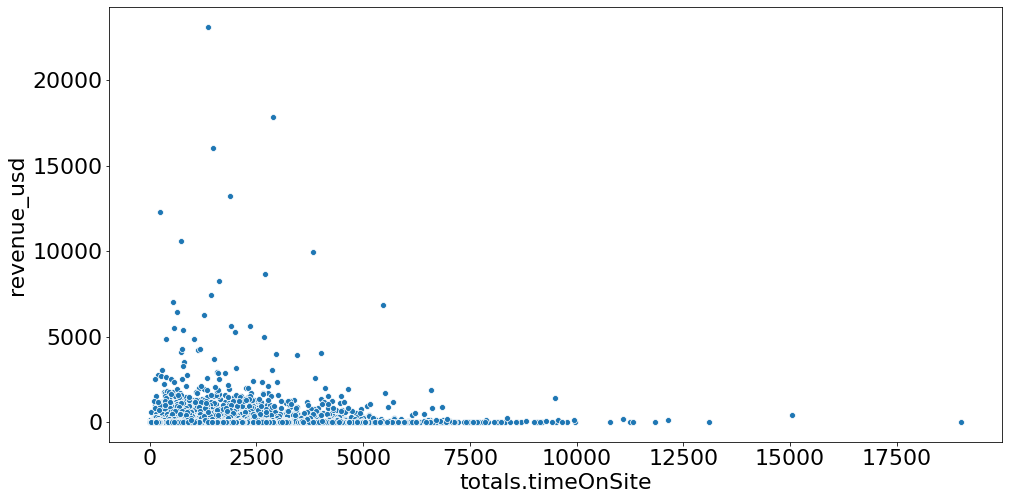

In [95]:
# Revenue vs Time Spent on Site
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='totals.timeOnSite', y='revenue_usd', data=df)

# Price of the Last Product Viewed

Most products viewed are relatively cheap (<$100). Some products have much higher price points.  These outliers may be removed from future iterations of this project.

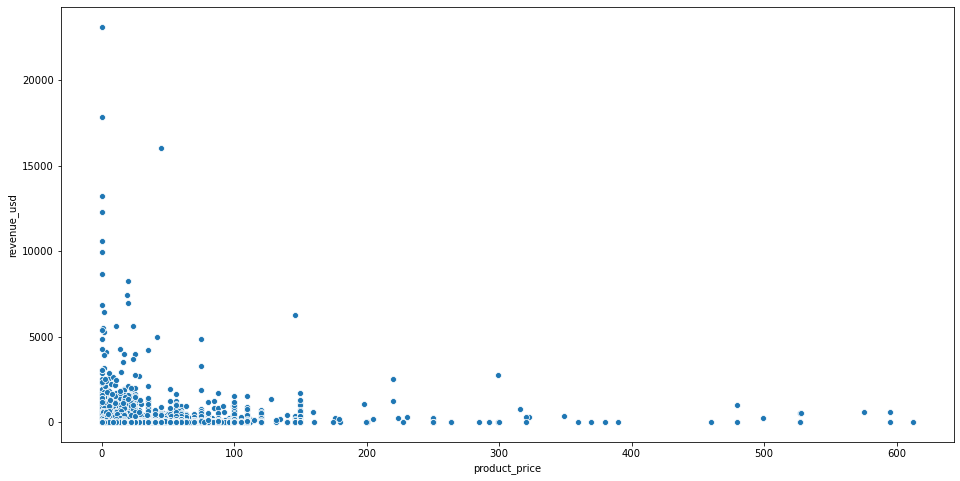

In [12]:
# Revenue vs Price of Last Product
plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='product_price', y='revenue_usd', data=df)